# Model proto

This is a rough prototype of our RL solution

In [1]:
import os
if os.getcwd() == '/kaggle/working':
    import sys
    
    !rm -rf 'PMLDL-Project'
    !git clone -b main https://github.com/Sambura/PMLDL-Project
    
    if 'PMLDL-Project' not in sys.path: sys.path.append('PMLDL-Project')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent_pg import DnDAgentPolicyGradient
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.agent.training import *
from src.dnd.game_configs import *

In [4]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [5]:
def train_loop_sequential_V1_PG(agent: DnDAgent, 
                                game: DnDBoard,
                                reward_fn: callable,
                                iter_limit: int=10000,
                                raise_on_limit: bool=False) -> int:
    if not agent.sequential_actions:
        raise RuntimeWarning('Provided agent is incompatible with this train loop')

    # enemy_memory = []
    for iter_count in range(iter_limit):
        unit, player_id = game.current_unit, game.current_player_id

        while game.current_movement_left > 0 or not game.used_action: # while unit is still able to do something
            state, action_vector, new_coords, action = get_states_seq(game, agent)
            action_legal, move_legal = None, None

            if new_coords is not None: # move to new_coords
                move_legal, updates = game.move(new_coords, raise_on_illegal=False)
                finish_turn = not move_legal
            elif action is not None: # invoke the action
                action_legal, updates = game.use_action(action, raise_on_illegal=False)
                finish_turn = not action_legal
            else:
                finish_turn = True
                updates = None

            game_state = game.get_game_state(player_id)
            reward = reward_fn(game, game_state, unit, player_id, move_legal, action_legal, updates)
            if player_id == 0: 
                agent.memorize(state, action_vector, reward)
            # else:
            #     enemy_memory.append((state, action_vector, reward))

            if game_state != GameState.PLAYING: 
                # agent.learn()

                # for memory in enemy_memory:
                #     agent.memorize(*memory)
                # agent.learn()
                
                return iter_count + 1

            if finish_turn: break

        game.finish_turn()
    
    if raise_on_limit: raise RuntimeError('Iteration limit exceeded')

    # agent.learn()
# 
    # for memory in enemy_memory:
    #     agent.memorize(*memory)
    # agent.learn()

    return iter_limit

In [ ]:
def calculate_reward_classic_seq_PG(game, game_state, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
    reward = 0

    if move_legal is not None: # agent (tried) to move
        if not move_legal: return reward

        units_removed = updates['units_removed'] # only possible if move_legal == True

        # penalty for killing yourself
        if len(game.players_to_units[player_id]) == 0:
            reward -= 1

        return reward
    elif action_legal is not None: # agent (tried) to invoke action
        if not action_legal: return reward

        units_removed = updates['units_removed'] # only possible if action_legal == True

        # reward for removing enemy units
        reward += len([x for x in units_removed if x[1] != player_id])

        # reward for defeating players
        reward += 5 * len([x for x in units_removed if len(game.players_to_units[x[1]]) == 0 and x[1] != player_id])

        # reward for winning
        if len(game.players_to_units[player_id]) == len(game.units):
            reward += 10

        return reward
    
    # agent passed
    return reward

In [6]:
#board_size = (8, 8)
board_size, game_config = get_2v2_0_config()
agent = DnDAgentPolicyGradient(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=3, 
    lr=1e-3, 
    gamma=0.99,
    batch_size=32, 
    memory_capacity=50000,
    model_class=DnDEvalModelRT5,
    sequential_actions=True
)

train_loop = train_loop_sequential_V1_PG
reward_policy = calculate_reward_classic_seq_PG

In [7]:
games = 50000
checkpoint_interval = 4000
game_iter_limit = 2500
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/'
generation_name = '_temp'
gen_header = \
'''# New field generation test

'''

In [8]:
iters, checkpoints, rewards = [], [], []
mag1s, mag2s = [], []

def pg_memorize(state, actions, reward, new_state, game_over):
    agent.memorize(state, actions, reward)

gen = fieldGenerator(board_size=board_size).load_from_folder('../Tokens')

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path, exist_ok=generation_name.startswith('_temp'))
else: gen_path = '..' # so that checkpoints still work

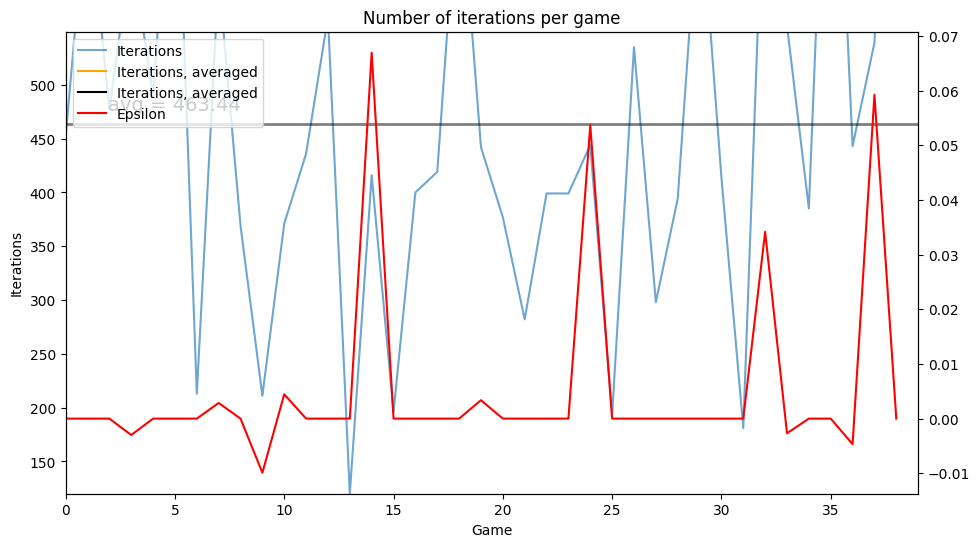

Training:   0%|          | 38/50000 [01:03<22:09:01,  1.60s/it]

KeyboardInterrupt: 

In [9]:
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = generate_balanced_game(board_size, game_config)
        
        # outputs = agent.predict(game.observe_board())
        # metric = np.mean(np.abs(outputs), axis=(1, 2))
        # mag1s.append(metric[0])
        # mag2s.append(metric[1])
        # pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        iter_count = train_loop(agent, game, reward_policy, iter_limit=game_iter_limit, raise_on_limit=False)
        iters.append(iter_count)
        rewards.append(np.mean(agent.reward_memory[:agent.memory_position]))
        agent.learn()

        ctime = time.time()
        if ctime - last_update > 20:
            clear_output(wait=True)
            plot_training_history(iters, rewards, checkpoints=checkpoints, min_ymax=30, average_last=average_result_over)
            if hasattr(pbar, 'container'): display(pbar.container)
            last_update = ctime

        iter_i = len(iters)
        if iter_i - last_checkpoint >= checkpoint_interval:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-average_result_over:]) # recent performance
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{avg:0.1f}i-{iter_i / 1000:0.1f}k'))

In [ ]:
plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=20, figsize=(20, 10), show=False)
if report_results:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
if report_results:
    plt.savefig(os.path.join(gen_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [ ]:
if report_results:
    actual_games = len(iters)

    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after {actual_games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")

# Configuration

```python


games = {actual_games}
```
''')

In [ ]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

In [ ]:
gen.reset()
game, colormap = decorate_game(gen.generate_balanced_game(targetCR=1))

agents_play_loop(agent, agent, game, colormap, reset_epsilon=False, delay=1)

# Visualization

In [ ]:
gen.reset()
game, colormap = decorate_game(gen.generate_balanced_game(targetCR=1))
print_game(game, colormap)

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

print(agent.choose_action_vector(state))